### Učitavanje potrebnih biblioteka

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_curve
from itertools import combinations
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import timm
import os
import shutil
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from tqdm.notebook import tqdm


### Učitavanje seta podataka

In [3]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [55]:
main_data_folder = './data/people/'
train_folder = './data/train/'
valid_folder = './data/valid/'

# Remove existing train, valid, and test folders (if they exist)
for folder in [train_folder, valid_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder and its contents

# Create destination folders
for folder in [train_folder, valid_folder]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(main_data_folder):
    class_path = os.path.join(main_data_folder, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    # List all images in the class folder
    images = os.listdir(class_path)

    # Create class subfolders in train, valid, and test directories
    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_folder, class_name), exist_ok=True)

    valid_images = images[:20]  # Second image for validation
    train_images = images[20:]  # Remaining images for training

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_folder, class_name, img))

    print(f"Class {class_name}: {len(train_images)} train, {len(valid_images)} validation images.")

Class Angelina Jolie: 80 train, 20 validation images.
Class Brad Pitt: 80 train, 20 validation images.
Class Denzel Washington: 80 train, 20 validation images.
Class Hugh Jackman: 80 train, 20 validation images.
Class Jennifer Lawrence: 80 train, 20 validation images.
Class Johnny Depp: 80 train, 20 validation images.
Class Kate Winslet: 80 train, 20 validation images.
Class Leonardo DiCaprio: 80 train, 20 validation images.
Class Megan Fox: 80 train, 20 validation images.
Class Natalie Portman: 80 train, 20 validation images.
Class Nicole Kidman: 80 train, 20 validation images.
Class Robert Downey Jr: 80 train, 20 validation images.
Class Sandra Bullock: 80 train, 20 validation images.
Class Scarlett Johansson: 180 train, 20 validation images.
Class Tom Cruise: 80 train, 20 validation images.
Class Tom Hanks: 80 train, 20 validation images.
Class Will Smith: 80 train, 20 validation images.


In [56]:
# Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
train_dataset = FaceDataset(train_folder, transform=train_transform)
val_dataset = FaceDataset(valid_folder, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


### Treniranje modela

In [16]:
class FaceClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FaceClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces spatial dimensions by half
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces spatial dimensions by half again
        )
        self.flatten = nn.Flatten()
        self.fc1 = None  # Placeholder for the dynamically defined layer
        self.classifier = None  # Placeholder for the classifier layer
        self.num_classes = num_classes

    def forward(self, x):
        # Pass through feature extractor
        x = self.features(x)

        # Dynamically calculate flattened size for fully connected layer
        if self.fc1 is None:
            flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(flattened_size, 512).to(x.device)
            self.classifier = nn.Linear(512, self.num_classes).to(x.device)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.classifier(x)
        return x


In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x

In [58]:
num_classes = len(train_dataset.classes)

model = torchvision.models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace classifier
model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 256),  # Add intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

C:\Users\Vedran\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vedran\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training loop

In [60]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_losses, val_losses = [], []
best_val_loss = float('inf')

# Ensure the models directory exists
os.makedirs('./models/', exist_ok=True)

# Dynamic epoch control
while True:
    try:
        # Ask the user how many epochs to run
        num_epochs = int(input("How many epochs would you like to train for? (Enter 0 to stop): "))
        if num_epochs <= 0:
            print("Training stopped by user.")
            break

        for epoch in range(1, num_epochs + 1):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch} - Training loop'):
                # Move inputs and labels to the device
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
            
            train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f'Epoch {epoch} - Validation loop'):
                    # Move inputs and labels to the device
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item() * labels.size(0)
            
            val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            # Print progress
            print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                model_path = f"./models/model_{timestamp}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"New best model saved at {model_path}")

            # Update the scheduler
            scheduler.step(val_loss)

        print(f"Completed {num_epochs} epochs.")
    
    except ValueError:
        print("Invalid input. Please enter a valid number.")

Epoch 1 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 2.4622, Validation loss: 1.9987
New best model saved at ./models/model_20250119_161042.pth


C:\Users\Vedran\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 1.8140, Validation loss: 1.6813
New best model saved at ./models/model_20250119_161412.pth


Epoch 3 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 1.4889, Validation loss: 1.5163
New best model saved at ./models/model_20250119_161741.pth


Epoch 4 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 1.1862, Validation loss: 1.3778
New best model saved at ./models/model_20250119_162113.pth


Epoch 5 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 1.0117, Validation loss: 1.2963
New best model saved at ./models/model_20250119_162446.pth
Completed 5 epochs.


Epoch 1 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.8197, Validation loss: 1.2701
New best model saved at ./models/model_20250119_162835.pth


Epoch 2 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.7107, Validation loss: 1.2321
New best model saved at ./models/model_20250119_163208.pth


Epoch 3 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.6075, Validation loss: 1.2133
New best model saved at ./models/model_20250119_163541.pth


Epoch 4 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.5406, Validation loss: 1.1663
New best model saved at ./models/model_20250119_163915.pth


Epoch 5 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.4978, Validation loss: 1.1306
New best model saved at ./models/model_20250119_164250.pth
Completed 5 epochs.


Epoch 1 - Training loop:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1 - Validation loop:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.4124, Validation loss: 1.1503
Completed 1 epochs.
Training stopped by user.


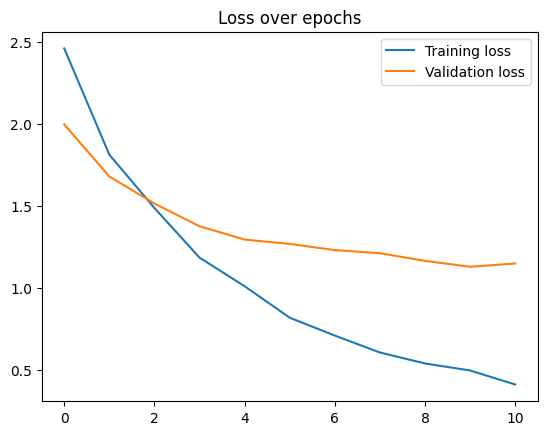

In [61]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Classes: ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


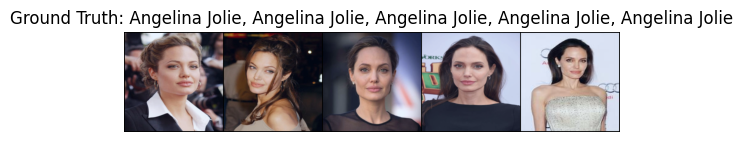

Predicted:  Kate Winslet, Angelina Jolie, Natalie Portman, Angelina Jolie, Angelina Jolie


In [72]:
# Function to display an image
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    if title:
        plt.title(title, fontsize=12)
    plt.show()

# Get 5 random images from the test_loader
def get_random_images(data_loader, num_images=5):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)  # Get a batch
    indices = random.sample(range(len(images)), num_images)  # Select `num_images` random indices
    return images[indices], labels[indices]

# Load class names from the training folder
train_folder = "./data/people/"
classes = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])
print(f"Classes: {classes}")

# Get random images and their labels
random_images, true_labels = get_random_images(val_loader, num_images=5)

# Display images and ground truth
grid = torchvision.utils.make_grid(random_images, nrow=5, padding=2, normalize=True)
imshow(grid, title="Ground Truth: " + ', '.join(classes[label] for label in true_labels))

# Model predictions
random_images = random_images.to(device)
true_labels = true_labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(random_images)
    _, predicted = torch.max(outputs, 1)

# Display predicted labels
print('Predicted: ', ', '.join(f'{classes[predicted[j]]}' for j in range(len(predicted))))


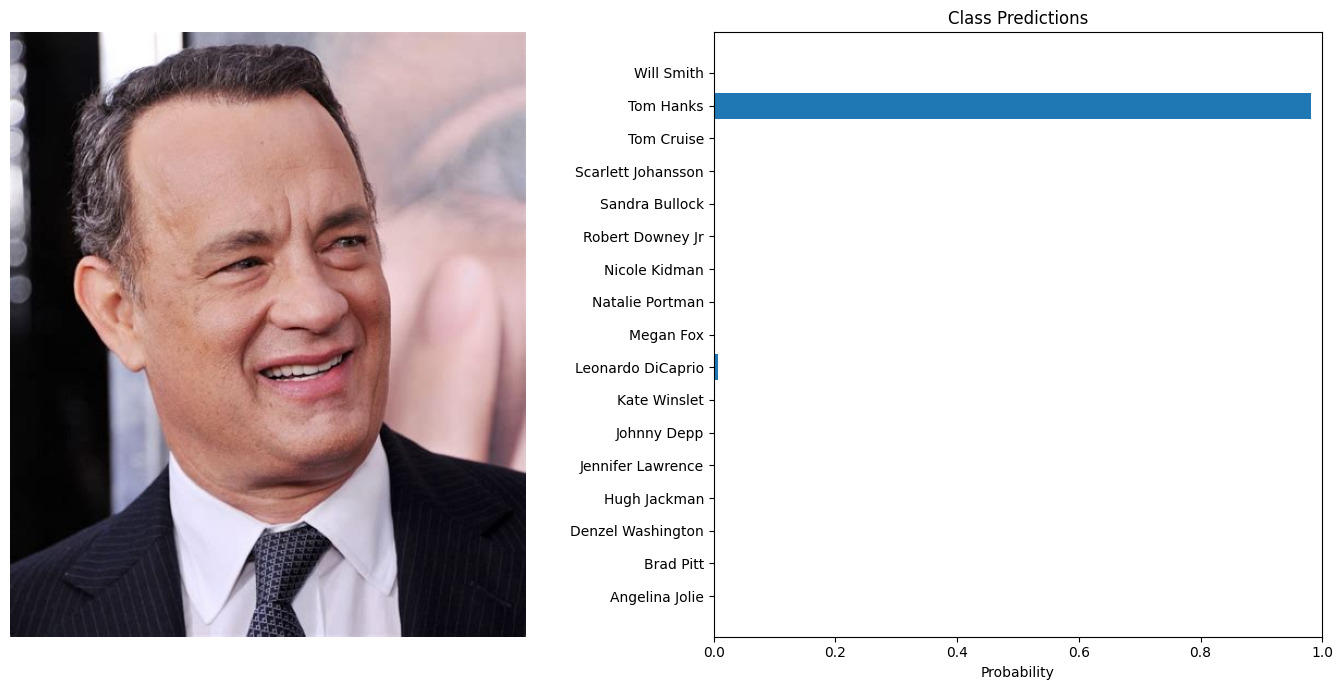

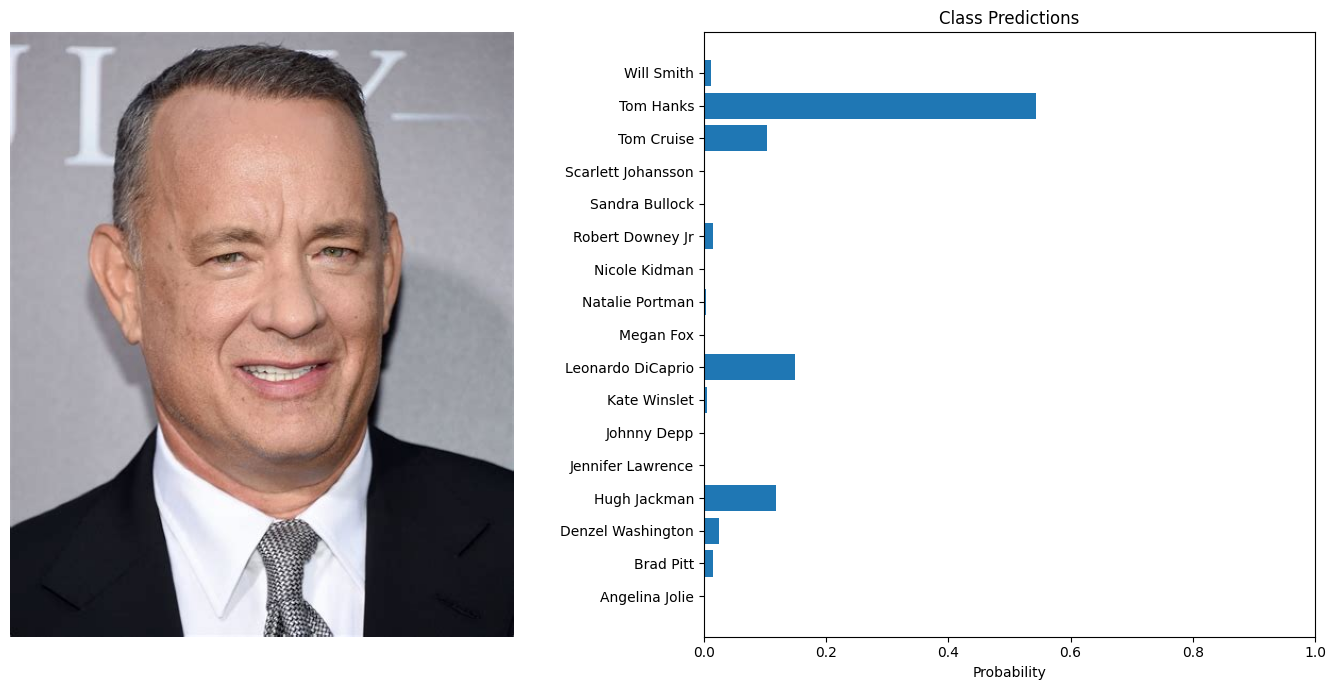

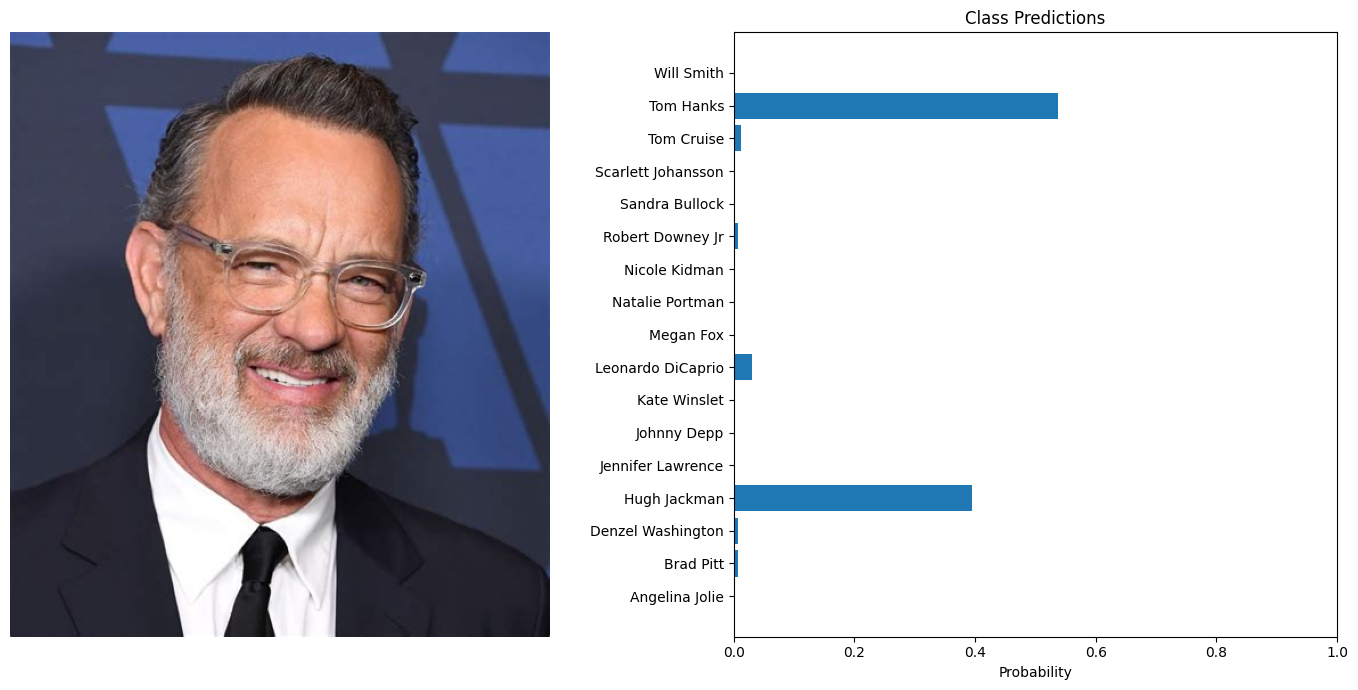

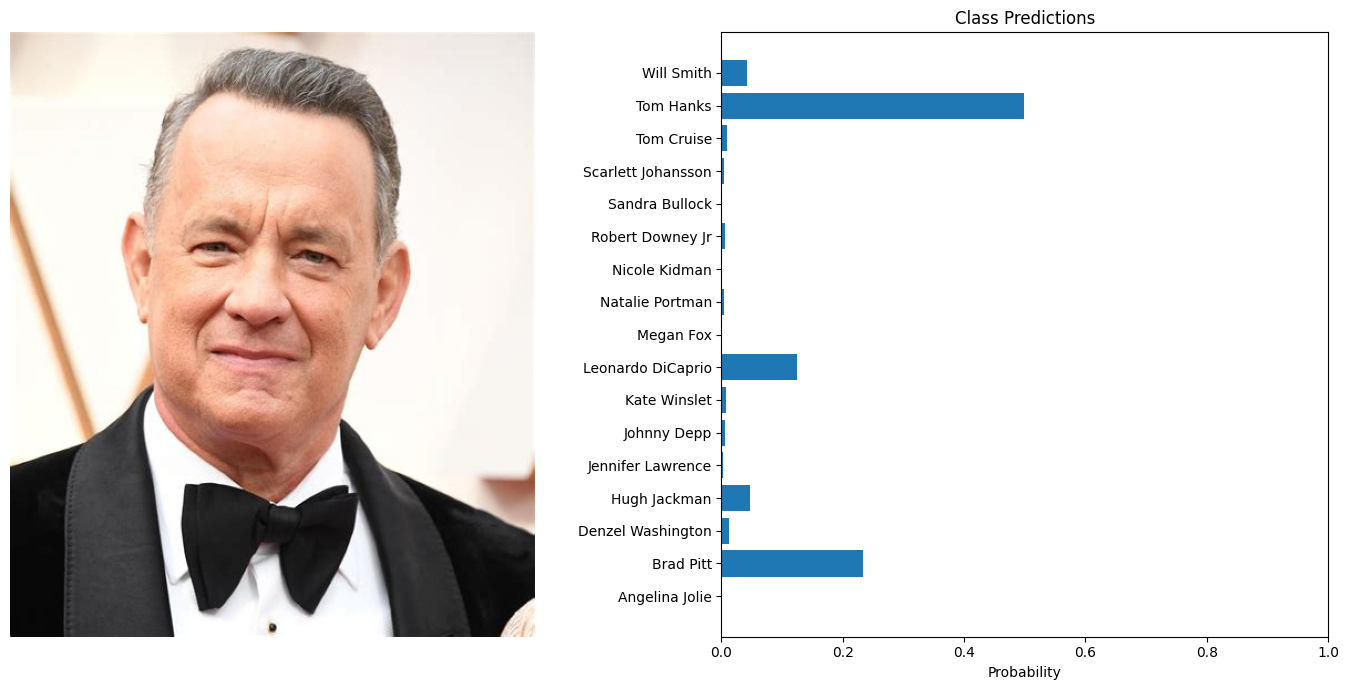

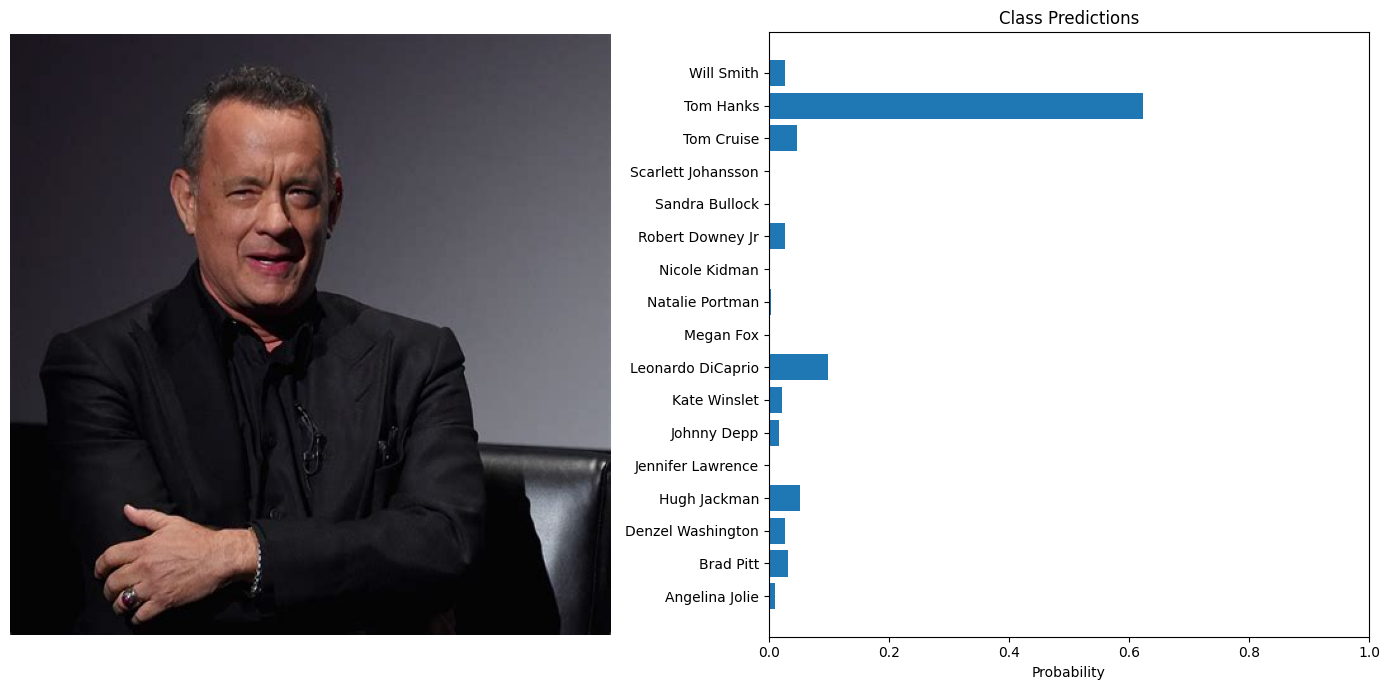

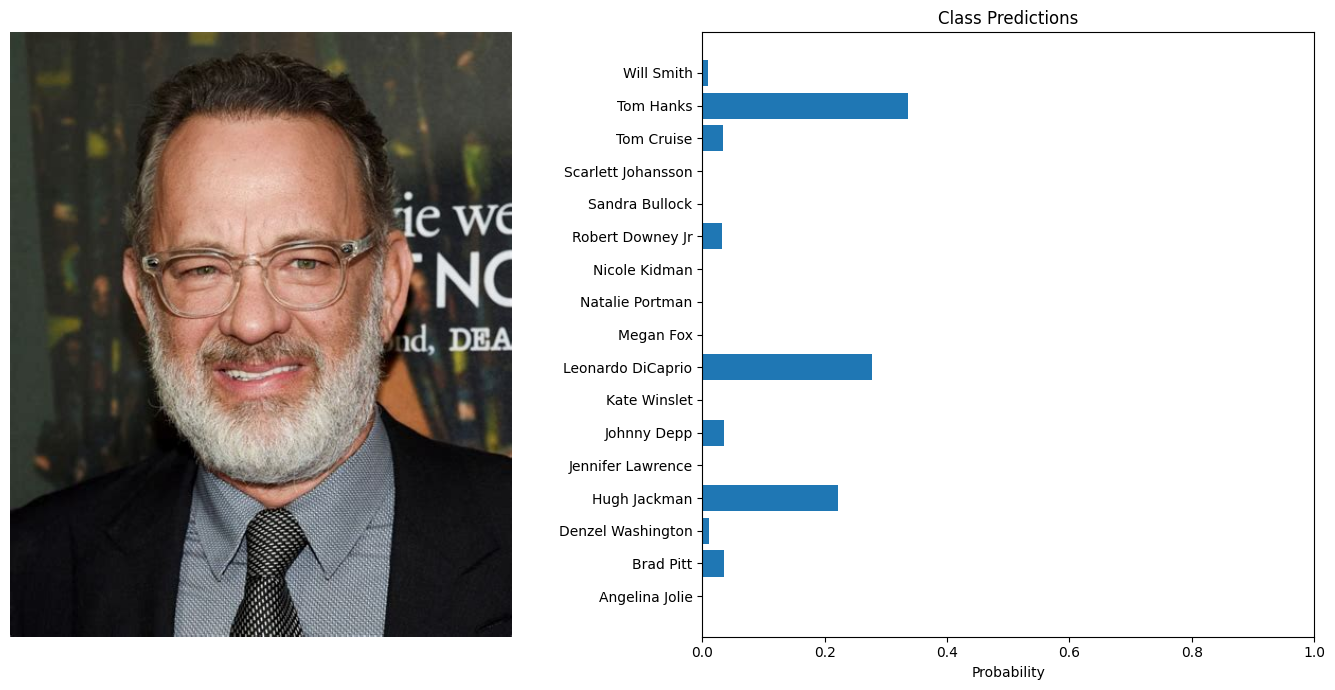

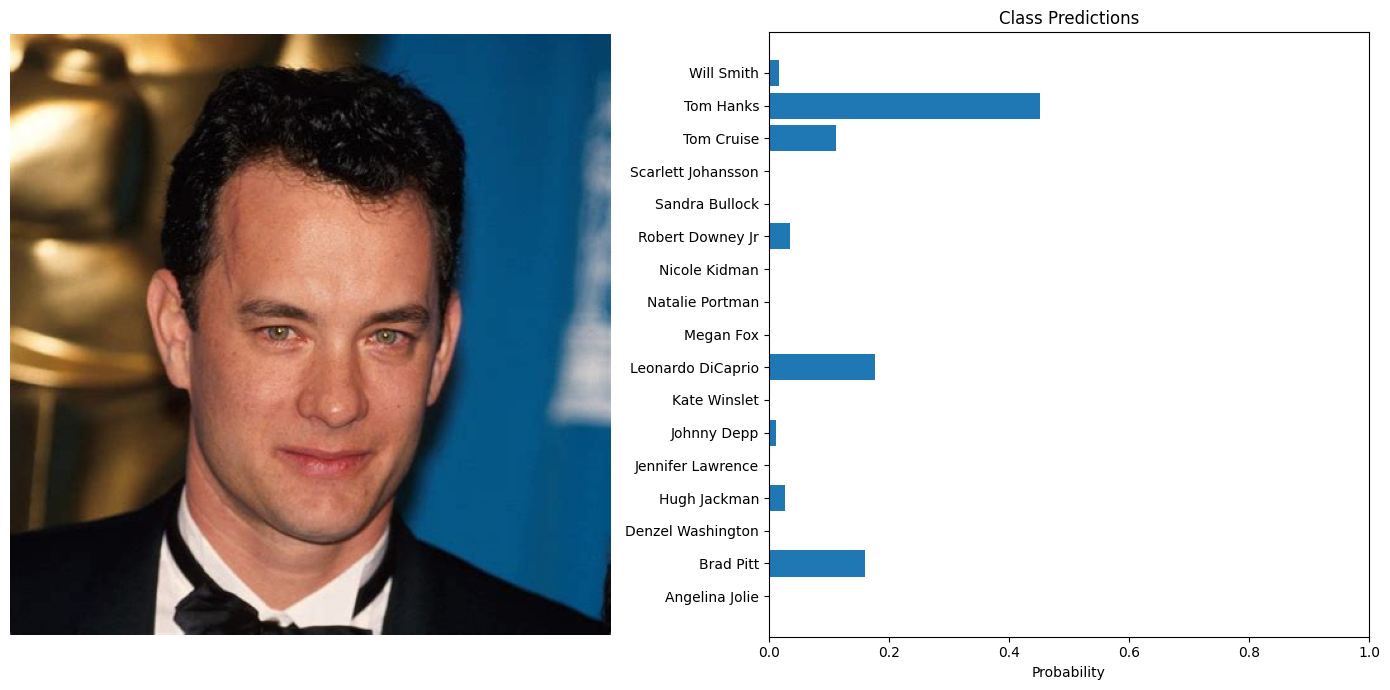

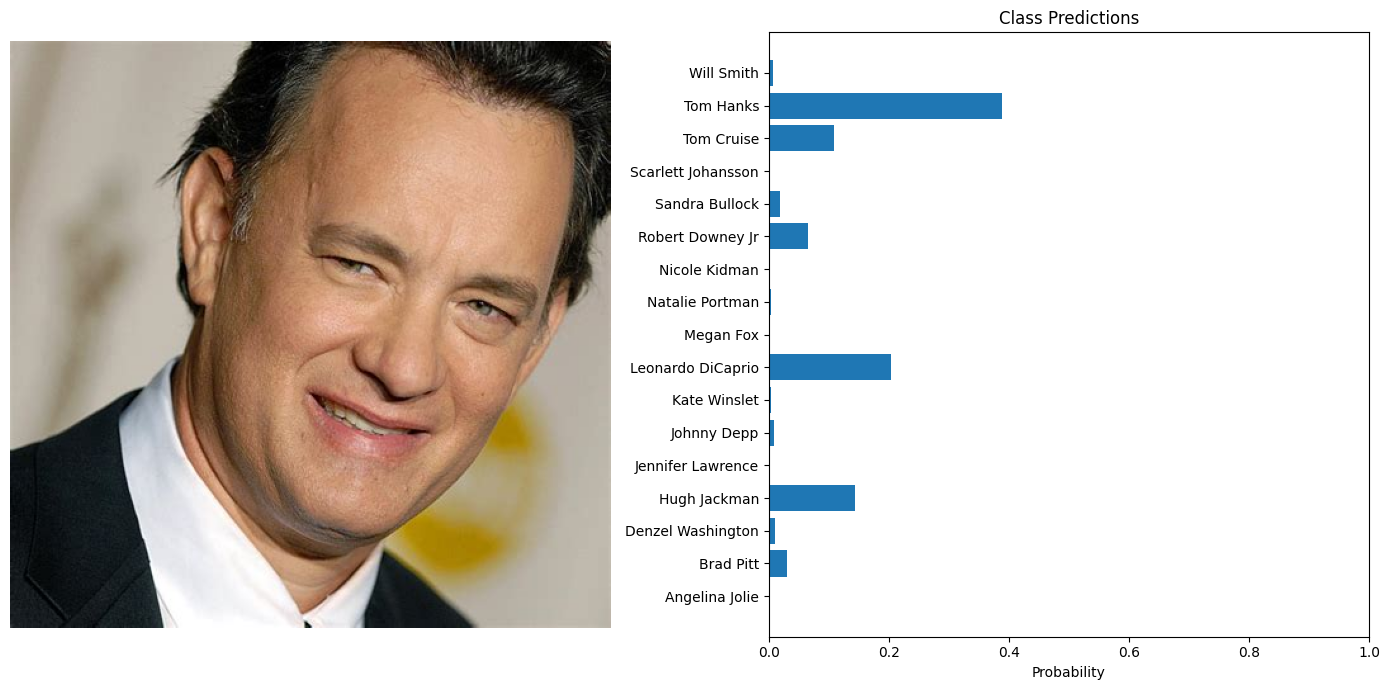

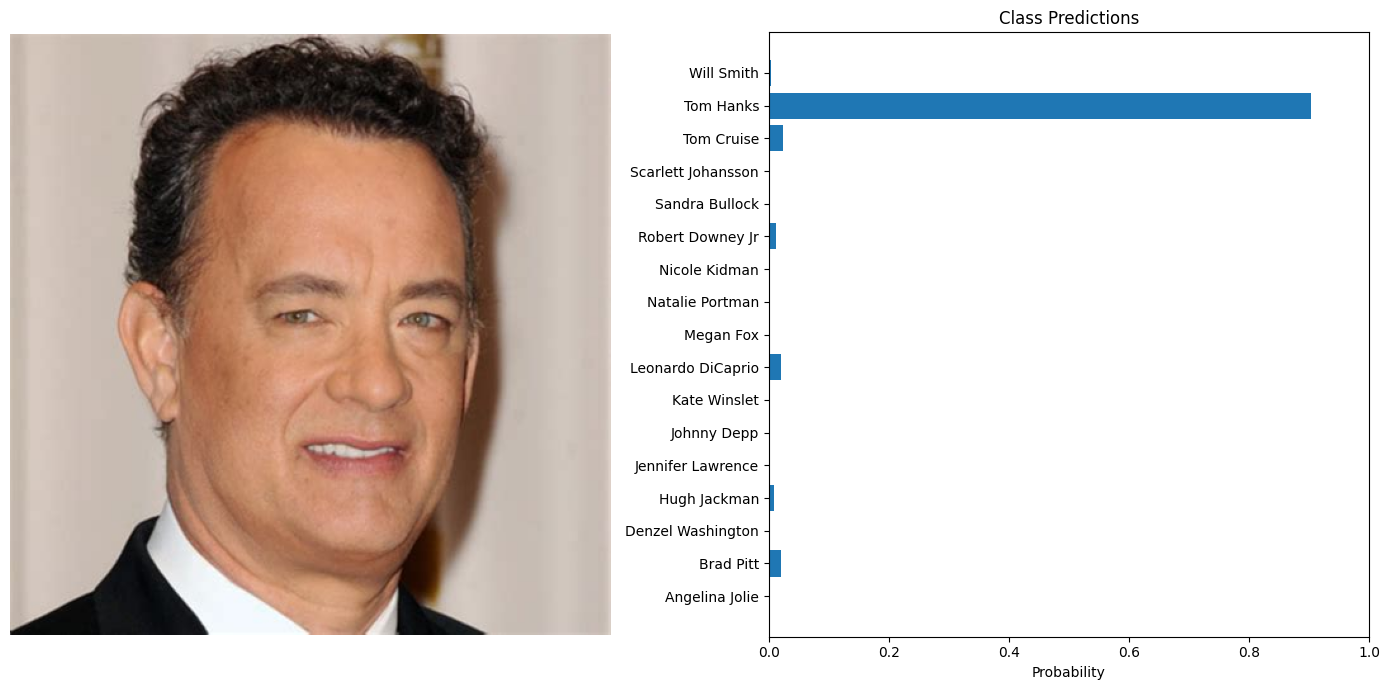

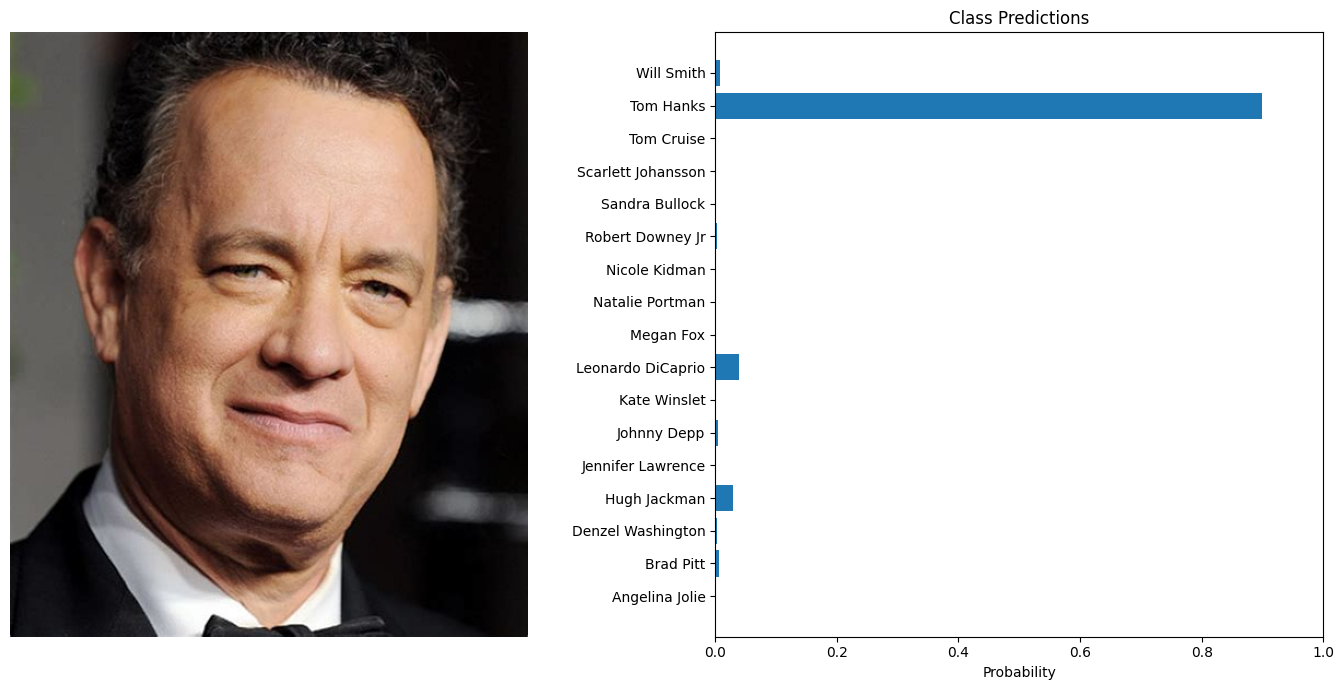

In [80]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
image_paths = [os.path.join("./data/valid/Tom Hanks", f) for f in os.listdir("./data/valid/Tom Hanks")]

for i in range(10):
    original_image, image_tensor = preprocess_image(image_paths[i], train_transform)

    # Make predictions
    probabilities = predict(model, image_tensor, device)

    # Visualize the predictions
    visualize_predictions(original_image, probabilities, classes)


In [87]:
import os
import random
from tqdm import tqdm

def generate_pairs(test_folder, valid_folder, max_pairs=5000):
    positive_pairs = []
    negative_pairs = []
    
    # Combine test and validation folders
    all_folders = [test_folder, valid_folder]
    
    # Get the classes from the test and validation folders
    class_folders = {}
    for folder in all_folders:
        class_folders[folder] = os.listdir(folder)
    
    # Create a dictionary to combine test and validation images for each class
    combined_classes = {}
    for folder in all_folders:
        for class_name in class_folders[folder]:
            class_path = os.path.join(folder, class_name)
            images = os.listdir(class_path)
            
            if class_name not in combined_classes:
                combined_classes[class_name] = []
            combined_classes[class_name].extend([os.path.join(class_path, img) for img in images])
    
    # Now we have the combined images for each class, let's generate pairs
    for _ in tqdm(range(max_pairs), desc="Generating pairs"):
        # Randomly choose a class that has images from both test and validation
        class_name = random.choice(list(combined_classes.keys()))
        images = combined_classes[class_name]

        # Create positive pair (same class, one image from test, one from validation)
        if len(images) > 1:
            img1, img2 = random.sample(images, 2)  # Randomly select 2 images for a positive pair
            positive_pairs.append((img1, img2))
        
        # Create negative pair (different classes)
        other_class_name = random.choice([name for name in combined_classes if name != class_name])
        other_class_images = combined_classes[other_class_name]
        
        if len(other_class_images) > 0:
            img1 = random.choice(images)  # Randomly select one image from the current class
            img2 = random.choice(other_class_images)  # Randomly select one image from the other class
            negative_pairs.append((img1, img2))
    
    print(f"Generated {len(positive_pairs)} positive pairs and {len(negative_pairs)} negative pairs.")
    return positive_pairs, negative_pairs

positive_pairs, negative_pairs = generate_pairs(valid_folder, valid_folder, max_pairs=1000)

Generating pairs: 100%|██████████| 1000/1000 [00:00<00:00, 250137.40it/s]

Generated 1000 positive pairs and 1000 negative pairs.


In [88]:
def test_model(model, positive_pairs, negative_pairs, transform, threshold=0.5):
    model.eval()

    all_labels = []
    all_scores = []

    def load_image(image_path):
        from PIL import Image
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        for pair, label in [(positive_pairs, 1), (negative_pairs, 0)]:
            for img1_path, img2_path in tqdm(pair, desc=f"Testing {'Positive' if label == 1 else 'Negative'} Pairs"):
                img1 = load_image(img1_path)
                img2 = load_image(img2_path)

                # Compute embeddings
                embedding1 = model(img1)
                embedding2 = model(img2)

                # Calculate distance
                distance = F.pairwise_distance(embedding1, embedding2).item()
                score = 1 - distance  # Higher score for closer embeddings

                all_scores.append(score)
                all_labels.append(label)

    # Calculate FAR, FRR, and EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    fnr = 1 - tpr

    # Calculate EER
    eer_threshold = thresholds[(np.abs(fpr - fnr)).argmin()]
    eer = fpr[(np.abs(fpr - fnr)).argmin()]
    return fpr, fnr, eer, eer_threshold

Testing Negative Pairs: 100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


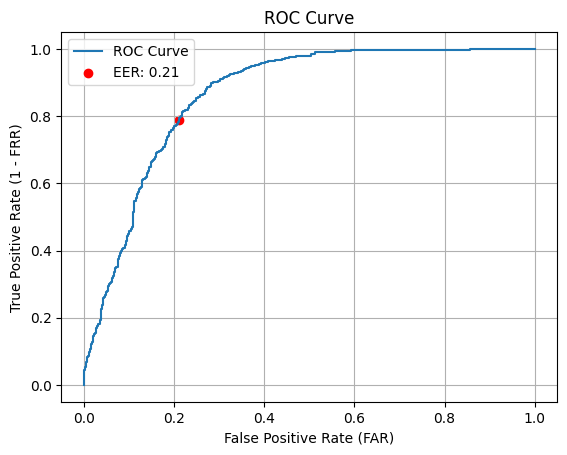

Equal Error Rate (EER): 0.212
Threshold at EER: -7.759896278381348


In [89]:
# Test the model
fpr, fnr, eer, eer_threshold = test_model(model, positive_pairs, negative_pairs, val_transform)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, 1 - fnr, label="ROC Curve")
plt.scatter([eer], [1 - eer], color='red', label=f"EER: {eer:.2f}")
plt.xlabel("False Positive Rate (FAR)")
plt.ylabel("True Positive Rate (1 - FRR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"Equal Error Rate (EER): {eer}")
print(f"Threshold at EER: {eer_threshold}")